In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 999
from dython.nominal import correlation_ratio
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_excel('CreditCard.xls', index_col=0)
a = df.iloc[0]
df = df[1:]
df.columns=a
df = df.astype('int64')
df

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Problems
- Beragamnya Tipe Pelanggan membuat pola pola tertentu terkait pembayaran Credit Card, apakah pembayaran akan dilakukan tepat waktu (normal) atau pembayaran akan terlambat.
- Apa yg sebaiknya dilakukan jika pembayaran terlambat

## Goals
- Membuat model yang mampu membuat prediksi apakah Suatu Pelanggan akan melakukan pembayaran Credit Card tepat waktu ataupun terlambat.
- Memberikan rekomendasi terkait Pelanggan yg melakukan pembayaran Credit Card terlambat ataupun tepat waktu

## Data Checking

In [3]:
Desc = []

for i in df.columns:
    Desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum() )/ len(df)) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])
    cek=pd.DataFrame(data = Desc,
            columns = [
                'Column',
                'DataType',
                'Null',
                'Null (%)',
                'nUnique',
                'Unique Samples'
            ])
print('Pengecekan Nama Column, Tipe Data, Missing Value dan Unique')
print('_'*60)
cek

Pengecekan Nama Column, Tipe Data, Missing Value dan Unique
____________________________________________________________


,Column,DataType,Null,Null (%),nUnique,Unique Samples
0,LIMIT_BAL,int64,0,0.0,81,"[610000, 240000]"
1,SEX,int64,0,0.0,2,"[2, 1]"
2,EDUCATION,int64,0,0.0,7,"[0, 6]"
3,MARRIAGE,int64,0,0.0,4,"[1, 2]"
4,AGE,int64,0,0.0,56,"[47, 34]"
5,PAY_0,int64,0,0.0,11,"[2, 5]"
6,PAY_2,int64,0,0.0,11,"[0, -2]"
7,PAY_3,int64,0,0.0,11,"[2, 4]"
8,PAY_4,int64,0,0.0,11,"[4, 0]"
9,PAY_5,int64,0,0.0,10,"[6, 8]"


## Check Outliers

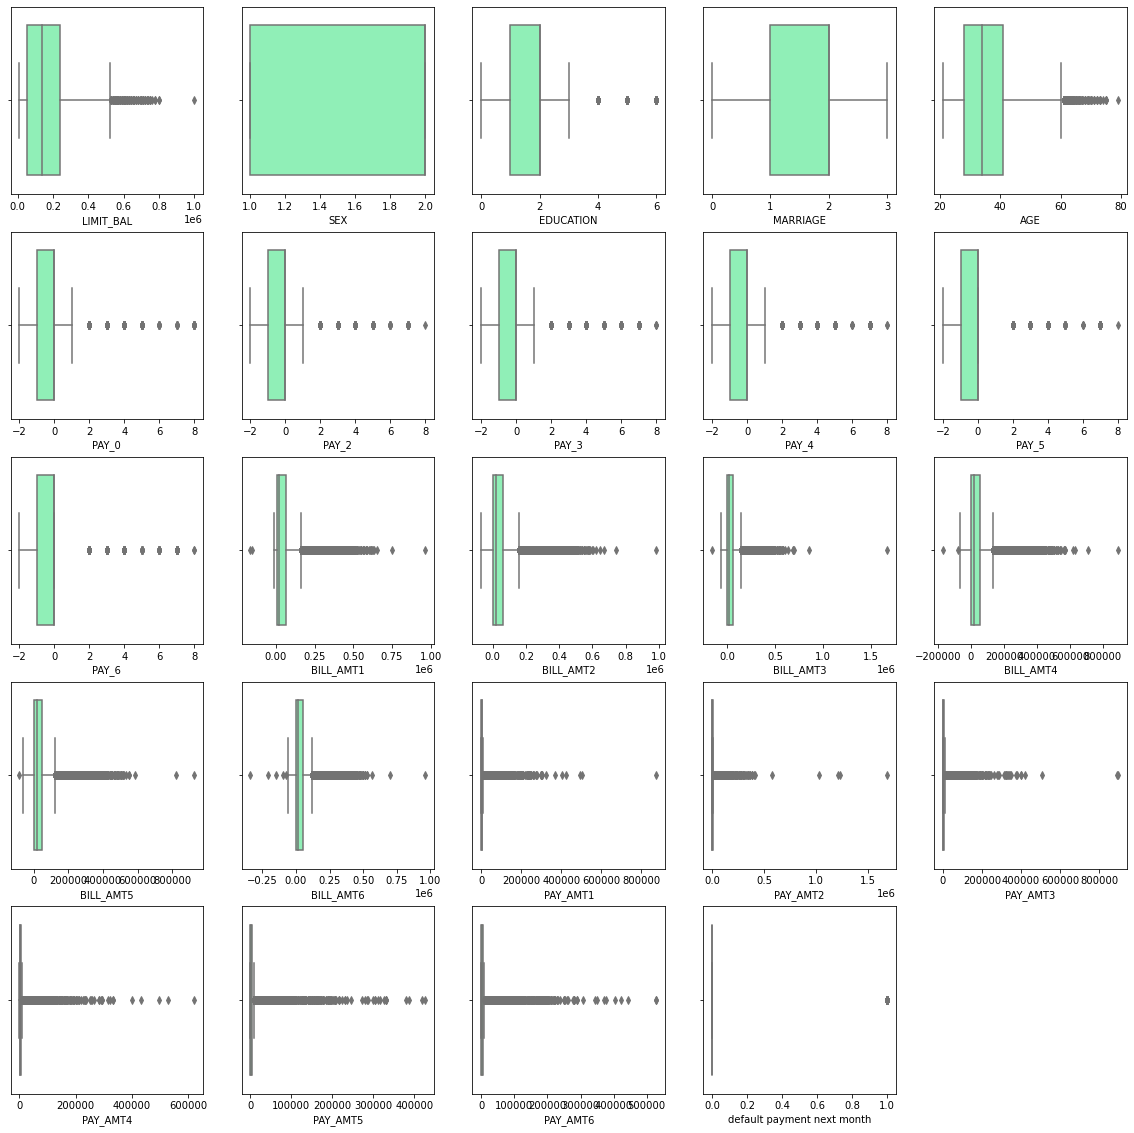

In [4]:
# Outliers by Boxplot
df_describe = df
plt.figure(figsize =(20, 20 ))
x = 1 

for column in df_describe.columns:
    plt.subplot(5,5,x)
    sns.boxplot(x=df_describe[column], palette='rainbow')
    x+=1
plt.tight_layout
plt.show()

In [5]:
# Outliers by Tabular
Desc_outliers = []
hitung = 0

for i in df:
    Q1 = df.describe()[i]['25%']
    Q3 = df.describe()[i]['75%']
    IQR = Q3 - Q1
    upper_fence = Q3 + (1.5*IQR)
    lower_fence = Q1 - (1.5*IQR)
    
    for j in df[i]:
        if (j < lower_fence) | (j > upper_fence) :
            hitung+=1
    Desc_outliers.append([
        i,
        hitung
    ])

pd.DataFrame(Desc_outliers, columns=[
    "Data Features",
    "Jumlah Outliers"
])

,Data Features,Jumlah Outliers
0,LIMIT_BAL,167
1,SEX,167
2,EDUCATION,621
3,MARRIAGE,621
4,AGE,893
5,PAY_0,4023
6,PAY_2,8433
7,PAY_3,12642
8,PAY_4,16150
9,PAY_5,19118


## Descriptive Statistic

In [6]:
df.describe()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Pengecekan Kolom Target

In [7]:
df['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [8]:
df['default payment next month'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

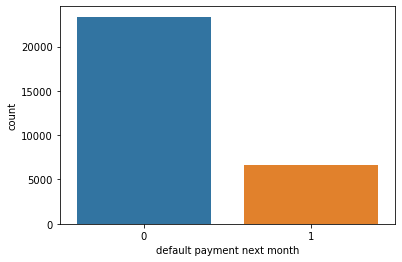

In [9]:
# plt.figure(figsize=(12,8))
sns.countplot('default payment next month',data=df)
plt.show()

### Insight
Data Imbalanced dimana 1 menjadi Minority
- 0 => Normal
- 1 => Telat

## Data Exploratory

In [10]:
pd.pivot_table(data=df, index='default payment next month', columns=['SEX'], aggfunc='count').drop(columns=['AGE','EDUCATION','MARRIAGE','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL       
SEX                                1      2
default payment next month                 
0                               9015  14349
1                               2873   3763

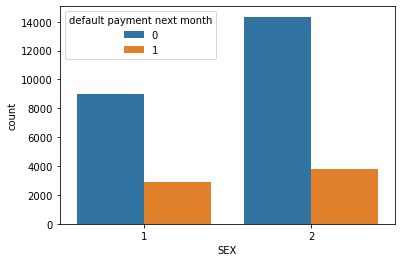

In [11]:
sns.countplot('SEX',data=df, hue='default payment next month')
plt.show()

### Insight
- Perbandingan Sex Male Default 0 dan Default 1 adalah 9015 normal ndan 2873 telat
- Perbandingan Sex Female Default 0 dan Default 1 adalah 14349 normal ndan 3763 telat

In [12]:
df['EDUCATION'] = df['EDUCATION'].map({0:4,1:1,2:2,3:3,4:4,5:4,6:4})
pd.pivot_table(data=df, index='default payment next month', columns=['EDUCATION'], aggfunc='count').drop(columns=['AGE','SEX','MARRIAGE','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL                  
EDUCATION                          1      2     3    4
default payment next month                            
0                               8549  10700  3680  435
1                               2036   3330  1237   33

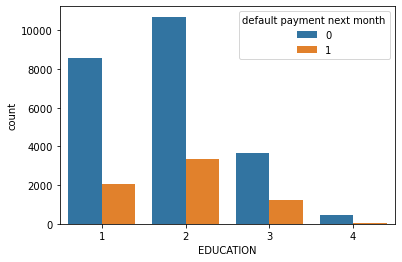

In [13]:
sns.countplot('EDUCATION',data=df, hue='default payment next month')
plt.show()

### Insight
- Perbandingan Education Graduate Default 0 dan Default 1 adalah 8549 normal ndan 2036 telat
- Perbandingan Education University Default 0 dan Default 1 adalah 10700 normal ndan 3330 telat
- Perbandingan Education High School Default 0 dan Default 1 adalah 3680 normal ndan 1237 telat
- Perbandingan Education Others Default 0 dan Default 1 adalah 435 normal ndan 33 telat

In [14]:
df['MARRIAGE'] = df['MARRIAGE'].map({0:3,1:1,2:2,3:3})
pd.pivot_table(data=df, index='default payment next month', columns=['MARRIAGE'], aggfunc='count').drop(columns=['AGE','SEX','EDUCATION','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL            
MARRIAGE                           1      2    3
default payment next month                      
0                              10453  12623  288
1                               3206   3341   89

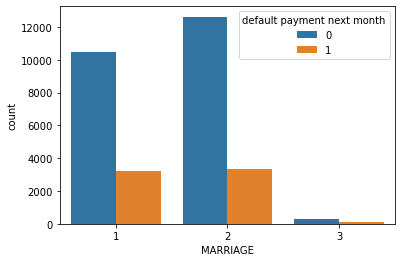

In [15]:
sns.countplot('MARRIAGE',data=df, hue='default payment next month')
plt.show()

### Insight
- Perbandingan Marriage Married Default 0 dan Default 1 adalah 10453 normal ndan 3206 telat
- Perbandingan Marriage Single Default 0 dan Default 1 adalah 12623 normal ndan 3341 telat
- Perbandingan Marriage Others Default 0 dan Default 1 adalah 288 normal ndan 89 telat

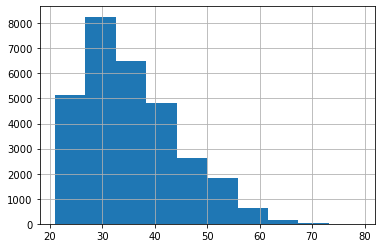

In [16]:
df['AGE'].hist()
plt.show()

In [17]:
# Re-Categorize AGE
bin_AGE = [(df['AGE'].min()-1), 30,40,50,60,70, df['AGE'].max()]
label_AGE = ['20s','30s','40s','50s','60s','70s']
df['age_cat'] = pd.cut(df['AGE'], bins=bin_AGE, labels=label_AGE)
pd.pivot_table(data=df, index='default payment next month', columns=['age_cat'], aggfunc='count').drop(columns=['AGE','MARRIAGE','SEX','EDUCATION','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL                           
age_cat                          20s   30s   40s   50s  60s 70s
default payment next month                                     
0                               8542  8524  4606  1493  189  10
1                               2471  2189  1399   504   68   5

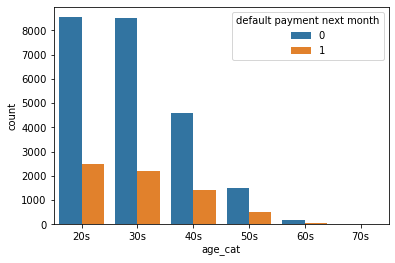

In [18]:
sns.countplot('age_cat',data=df, hue='default payment next month')
plt.show()

### Insight
- Perbandingan Age 20s Default 0 dan Default 1 adalah 8542 normal ndan 2471 telat
- Perbandingan Age 30s Default 0 dan Default 1 adalah 8524 normal ndan 2189 telat
- Perbandingan Age 40s Default 0 dan Default 1 adalah 4606 normal ndan 1399 telat
- Perbandingan Age 50s Default 0 dan Default 1 adalah 1493 normal ndan 504 telat
- Perbandingan Age 60s Default 0 dan Default 1 adalah 189 normal ndan 68 telat
- Perbandingan Age 70s Default 0 dan Default 1 adalah 10 normal ndan 5 telat

In [19]:
df['PAY_0'] = df['PAY_0'].map({-2:-1,-1:-1,0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8})
pd.pivot_table(data=df, index='default payment next month', columns=['PAY_0'], aggfunc='count').drop(columns=['age_cat','MARRIAGE','SEX','EDUCATION','AGE','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL                                          
PAY_0                             -1      0     1     2    3   4   5  6  7   8
default payment next month                                                    
0                               7126  12849  2436   823   78  24  13  5  2   8
1                               1319   1888  1252  1844  244  52  13  6  7  11

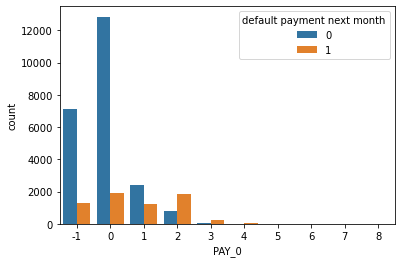

In [20]:

sns.countplot('PAY_0',data=df, hue='default payment next month')
plt.show()

### Insight
- Default 0 Normal paling banyak di pay_0 0 sebanyak 12849
- Default 1 Telat paling banyak di pay_0 0 sebanyak 1888

In [21]:
df['PAY_2'] = df['PAY_0'].map({-2:-1,-1:-1,0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8})
pd.pivot_table(data=df, index='default payment next month', columns=['PAY_2'], aggfunc='count').drop(columns=['age_cat','MARRIAGE','SEX','EDUCATION','AGE','PAY_0', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL                                          
PAY_2                             -1      0     1     2    3   4   5  6  7   8
default payment next month                                                    
0                               7126  12849  2436   823   78  24  13  5  2   8
1                               1319   1888  1252  1844  244  52  13  6  7  11

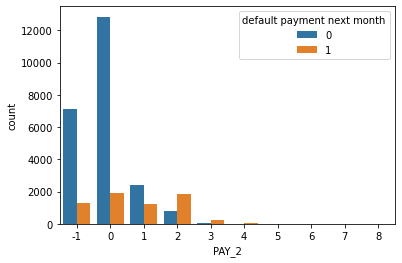

In [22]:
sns.countplot('PAY_2',data=df, hue='default payment next month')
plt.show()

### Insight
- Default 0 Normal paling banyak di pay_2 0 sebanyak 13227
- Default 1 Telat paling banyak di pay_2 0 sebanyak 2503

In [23]:
df['PAY_3'] = df['PAY_0'].map({-2:-1,-1:-1,0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8})
pd.pivot_table(data=df, index='default payment next month', columns=['PAY_3'], aggfunc='count').drop(columns=['age_cat','MARRIAGE','SEX','EDUCATION','AGE','PAY_0', 'PAY_2', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL                                          
PAY_3                             -1      0     1     2    3   4   5  6  7   8
default payment next month                                                    
0                               7126  12849  2436   823   78  24  13  5  2   8
1                               1319   1888  1252  1844  244  52  13  6  7  11

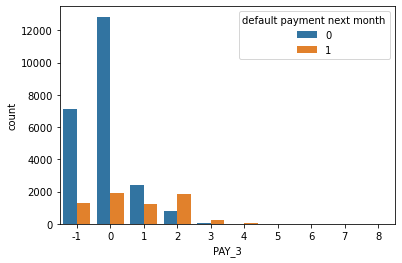

In [24]:
sns.countplot('PAY_3',data=df, hue='default payment next month')
plt.show()

### Insight
- Default 0 Normal paling banyak di pay_3 0 sebanyak 13013
- Default 1 Telat paling banyak di pay_3 0 sebanyak 2751

In [25]:
df['PAY_4'] = df['PAY_0'].map({-2:-1,-1:-1,0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8})
pd.pivot_table(data=df, index='default payment next month', columns=['PAY_4'], aggfunc='count').drop(columns=['age_cat','MARRIAGE','SEX','EDUCATION','AGE','PAY_0', 'PAY_2', 'PAY_3', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL                                          
PAY_4                             -1      0     1     2    3   4   5  6  7   8
default payment next month                                                    
0                               7126  12849  2436   823   78  24  13  5  2   8
1                               1319   1888  1252  1844  244  52  13  6  7  11

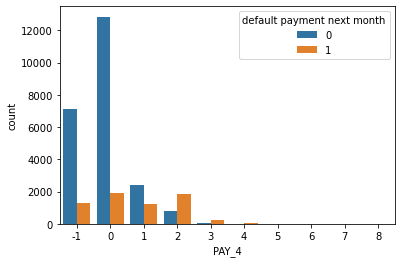

In [26]:
sns.countplot('PAY_4',data=df, hue='default payment next month')
plt.show()

### Insight
- Default 0 Normal paling banyak di pay_4 0 sebanyak 13439
- Default 1 Telat paling banyak di pay_4 0 sebanyak 3016

In [27]:
df['PAY_5'] = df['PAY_0'].map({-2:-1,-1:-1,0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8})
pd.pivot_table(data=df, index='default payment next month', columns=['PAY_5'], aggfunc='count').drop(columns=['age_cat','MARRIAGE','SEX','EDUCATION','AGE','PAY_0', 'PAY_2', 'PAY_4', 'PAY_3', 'PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL                                          
PAY_5                             -1      0     1     2    3   4   5  6  7   8
default payment next month                                                    
0                               7126  12849  2436   823   78  24  13  5  2   8
1                               1319   1888  1252  1844  244  52  13  6  7  11

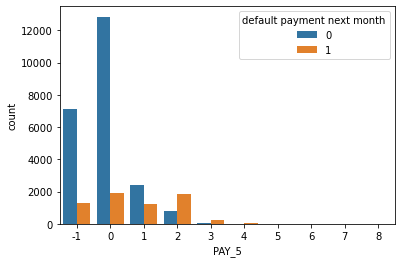

In [28]:
sns.countplot('PAY_5',data=df, hue='default payment next month')
plt.show()

### Insight
- Default 0 Normal paling banyak di pay_5 0 sebanyak 13752
- Default 1 Telat paling banyak di pay_5 0 sebanyak 3195

In [29]:
df['PAY_6'] = df['PAY_0'].map({-2:-1,-1:-1,0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8})
pd.pivot_table(data=df, index='default payment next month', columns=['PAY_6'], aggfunc='count').drop(columns=['age_cat','MARRIAGE','SEX','EDUCATION','AGE','PAY_0', 'PAY_2', 'PAY_4', 'PAY_3', 'PAY_5','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

ID                         LIMIT_BAL                                          
PAY_6                             -1      0     1     2    3   4   5  6  7   8
default payment next month                                                    
0                               7126  12849  2436   823   78  24  13  5  2   8
1                               1319   1888  1252  1844  244  52  13  6  7  11

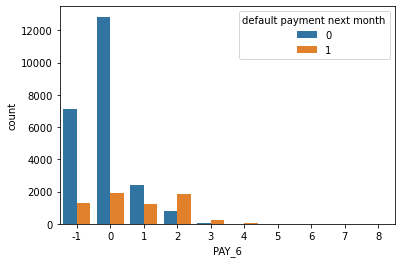

In [30]:
sns.countplot('PAY_6',data=df, hue='default payment next month')
plt.show()

### Insight
- Default 0 Normal paling banyak di pay_6 0 sebanyak 13217
- Default 1 Telat paling banyak di pay_6 0 sebanyak 3069

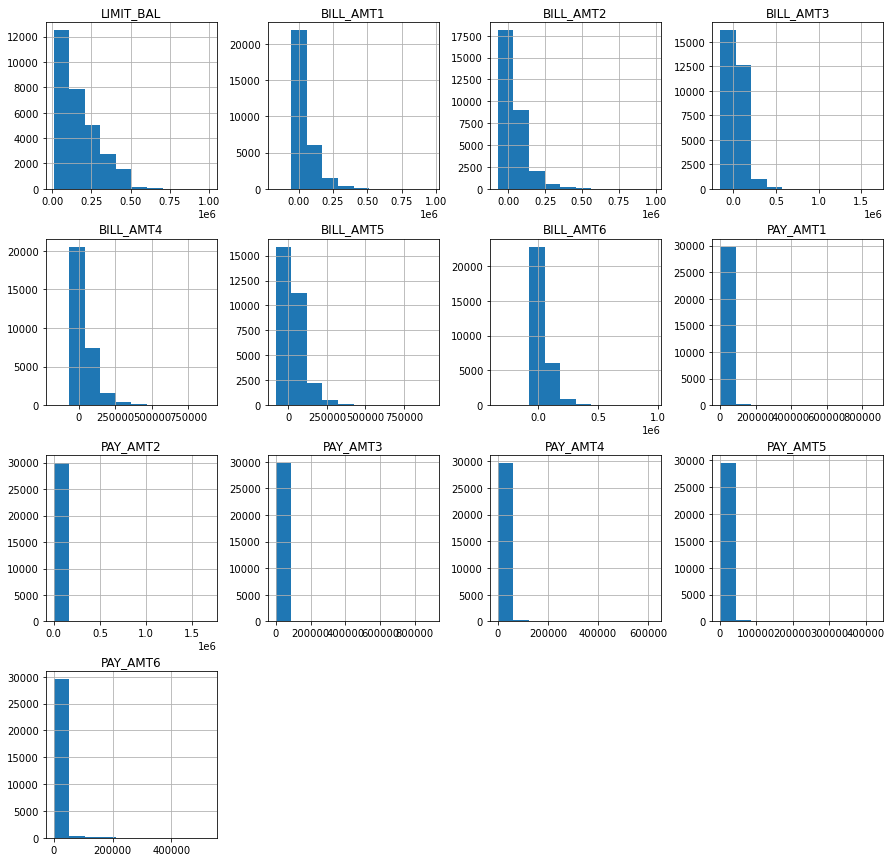

In [31]:
df[['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].hist(figsize=(15,15))
plt.show()

In [32]:
pd.pivot_table(data=df, index='default payment next month', aggfunc='mean').drop(columns=['AGE','EDUCATION','MARRIAGE','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','SEX']).round(2)

ID,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,LIMIT_BAL,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
default payment next month,,,,,,,,,,,,,
0,51994.23,49717.44,47533.37,43611.17,40530.45,39042.27,178099.73,6307.34,6640.47,5753.50,5300.53,5248.22,5719.37
1,48509.16,47283.62,45181.60,42036.95,39540.19,38271.44,130109.66,3397.04,3388.65,3367.35,3155.63,3219.14,3441.48


### Insight
- Rata rata Jumlah Tagihan Bulan September adalah 
    - 51994.23 untuk Default 0
    - 48509.16 untuk Default 1
- Rata rata Jumlah Tagihan Bulan Agustus adalah 
    - 49717.44 untuk Default 0
    - 47283.62 untuk Default 1
- Rata rata Jumlah Tagihan Bulan July adalah 
    - 47533.37 untuk Default 0
    - 45181.60 untuk Default 1
- Rata rata Jumlah Tagihan Bulan June adalah 
    - 43611.17 untuk Default 0
    - 42036.95 untuk Default 1
- Rata rata Jumlah Tagihan Bulan May adalah 
    - 40530.45 untuk Default 0
    - 39540.19 untuk Default 1
- Rata rata Jumlah Tagihan Bulan April adalah 
    - 39042.27 untuk Default 0
    - 38271.44 untuk Default 1
    
<hr>
    
- Rata rata Limit Balance adalah 
    - 178099.73 untuk Default 0
    - 130109.66 untuk Default 1

<hr>

- Rata rata Jumlah Pembayaran Bulan September adalah 
    - 6307.34 untuk Default 0
    - 3397.04 untuk Default 1
- Rata rata Jumlah Pembayaran Bulan Agustus adalah 
    - 6640.47 untuk Default 0
    - 3388.65 untuk Default 1
- Rata rata Jumlah Pembayaran Bulan July adalah 
    - 5753.50 untuk Default 0
    - 3367.35 untuk Default 1
- Rata rata Jumlah Pembayaran Bulan June adalah 
    - 5300.53 untuk Default 0
    - 3155.63 untuk Default 1
- Rata rata Jumlah Pembayaran Bulan May adalah 
    - 5248.22 untuk Default 0
    - 3219.14 untuk Default 1
- Rata rata Jumlah Pembayaran Bulan April adalah 
    - 5719.37 untuk Default 0
    - 3441.48 untuk Default 1

## Data Preparation

In [33]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'age_cat'],
      dtype='object', name='ID')

In [34]:
df_ML = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
            'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','default payment next month']]
df_ML.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,2,2,2,2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,-1,-1,-1,-1,-1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,-1,-1,-1,-1,-1,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [35]:
X = df_ML.drop(columns='default payment next month')
y = df_ML['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=36)

### Base Model

In [36]:
num_columns = ['LIMIT_BAL','AGE','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_columns = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

categoric_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_SVM_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=400, probability=True)),
])

pipe_KNN_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier()),
])

pipe_LR_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression()),
])

pipe_DT_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', DecisionTreeClassifier(random_state=36))
])


pipe_RF_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(random_state=36)),
])

pipe_XGB_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier()),
])

### LogisticRegression - Base

In [37]:
pipe_LR_Base.fit(X_train, y_train)
ytr_lr_base = pipe_LR_Base.predict(X_train)
yts_lr_base = pipe_LR_Base.predict(X_test)

print(classification_report(y_train, ytr_lr_base))

In [38]:
print(classification_report(y_test, yts_lr_base))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      5841
           1       0.00      0.00      0.00      1659

    accuracy                           0.78      7500
   macro avg       0.39      0.50      0.44      7500
weighted avg       0.61      0.78      0.68      7500



In [39]:
pd.DataFrame(confusion_matrix(y_test, yts_lr_base, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
Akt 1,0,1659
Akt 0,3,5838


### KNN - Base

In [40]:
pipe_KNN_Base.fit(X_train, y_train)
ytr_knn_base = pipe_KNN_Base.predict(X_train)
yts_knn_base = pipe_KNN_Base.predict(X_test)

print(classification_report(y_train, ytr_knn_base))

In [41]:
print(classification_report(y_test, yts_knn_base))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      5841
           1       0.39      0.20      0.26      1659

    accuracy                           0.75      7500
   macro avg       0.59      0.55      0.56      7500
weighted avg       0.71      0.75      0.72      7500



In [42]:
pd.DataFrame(confusion_matrix(y_test, yts_knn_base, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
Akt 1,326,1333
Akt 0,514,5327


### SVM - Base

In [43]:
pipe_SVM_Base.fit(X_train, y_train)
ytr_svm_base = pipe_SVM_Base.predict(X_train)
yts_svm_base = pipe_SVM_Base.predict(X_test)

print(classification_report(y_train, ytr_svm_base))

In [44]:
print(classification_report(y_test, yts_svm_base))

              precision    recall  f1-score   support

           0       0.84      0.31      0.46      5841
           1       0.25      0.80      0.38      1659

    accuracy                           0.42      7500
   macro avg       0.55      0.55      0.42      7500
weighted avg       0.71      0.42      0.44      7500



In [45]:
pd.DataFrame(confusion_matrix(y_test, yts_svm_base, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
Akt 1,1320,339
Akt 0,4010,1831


### DecisionTree - Base

In [46]:
pipe_DT_Base.fit(X_train, y_train)
ytr_DT_base = pipe_DT_Base.predict(X_train)
yts_DT_base = pipe_DT_Base.predict(X_test)

print(classification_report(y_train, ytr_DT_base))

In [47]:
print(classification_report(y_test, yts_DT_base))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      5841
           1       0.39      0.42      0.40      1659

    accuracy                           0.73      7500
   macro avg       0.61      0.62      0.61      7500
weighted avg       0.73      0.73      0.73      7500



In [48]:
pd.DataFrame(confusion_matrix(y_test, yts_DT_base, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
Akt 1,696,963
Akt 0,1099,4742


### RandomForest - Base

In [49]:
pipe_RF_Base.fit(X_train, y_train)
ytr_RF_base = pipe_RF_Base.predict(X_train)
yts_RF_base = pipe_RF_Base.predict(X_test)

print(classification_report(y_train, ytr_RF_base))

In [50]:
print(classification_report(y_test, yts_RF_base))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.67      0.39      0.49      1659

    accuracy                           0.82      7500
   macro avg       0.76      0.67      0.69      7500
weighted avg       0.81      0.82      0.80      7500



In [51]:
pd.DataFrame(confusion_matrix(y_test, yts_RF_base, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
Akt 1,641,1018
Akt 0,318,5523


### XGB - Base

In [52]:
pipe_XGB_Base.fit(X_train, y_train)
ytr_XGB_base = pipe_XGB_Base.predict(X_train)
yts_XGB_base = pipe_XGB_Base.predict(X_test)

[14:31:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


print(classification_report(y_train, ytr_XGB_base))

In [53]:
print(classification_report(y_test, yts_XGB_base))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5841
           1       0.65      0.38      0.48      1659

    accuracy                           0.82      7500
   macro avg       0.74      0.66      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [54]:
pd.DataFrame(confusion_matrix(y_test, yts_XGB_base, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
Akt 1,627,1032
Akt 0,344,5497


## Parameter Tuning

### KNN - Hyperparameter Tuning

pipe_KNN_Base.get_params()

In [55]:
param_KNN_1 = {
    'algo__n_neighbors': np.arange(1,11,2),
    'algo__p': [1, 2],
    'algo__weights': ['uniform', 'distance'],
}
skf_KNN = StratifiedKFold(n_splits=3, shuffle=True, random_state=36)

In [56]:
KNN_1 = GridSearchCV(pipe_KNN_Base, param_KNN_1, cv = skf_KNN, scoring='recall', n_jobs=-1, verbose=1)
KNN_1.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=36, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'BILL_AMT1',
                                                                          'BILL_AMT2',
                                                                          'BILL_AMT3',
                                                                          'BILL_AMT4',
                                                                 

In [57]:
KNN_1 = KNN_1.best_estimator_
yts_KNN_1 = KNN_1.predict(X_test)
print(classification_report(y_test, yts_KNN_1))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      5841
           1       0.31      0.31      0.31      1659

    accuracy                           0.70      7500
   macro avg       0.56      0.56      0.56      7500
weighted avg       0.70      0.70      0.70      7500



In [58]:
pd.DataFrame(confusion_matrix(y_test, yts_KNN_1, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
Akt 1,511,1148
Akt 0,1122,4719


### SVM - Fine Tuning

In [63]:
param_SVM_1 = {
    'algo__C' : [10],
    'algo__gamma' : [10],
    'algo__class_weight' : [{0 : .4, 1 : .6}]
}
skf_SVM = StratifiedKFold(n_splits=3, shuffle=True, random_state=36)

In [64]:
SVM_1 = GridSearchCV(pipe_SVM_Base, param_SVM_1, cv = skf_SVM, scoring='recall', n_jobs=-1, verbose=1)
SVM_1.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=36, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'BILL_AMT1',
                                                                          'BILL_AMT2',
                                                                          'BILL_AMT3',
                                                                          'BILL_AMT4',
                                                                 

In [65]:
SVM_1 = SVM_1.best_estimator_
yts_SVM_1 = SVM_1.predict(X_test)
print(classification_report(y_test, yts_SVM_1))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      5841
           1       0.00      0.00      0.00      1659

    accuracy                           0.78      7500
   macro avg       0.39      0.50      0.44      7500
weighted avg       0.61      0.78      0.68      7500



In [75]:
pd.DataFrame(confusion_matrix(y_test, yts_SVM_1, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
Akt 1,0,1659
Akt 0,2,5839


### RandomForrest - Fine Tuning

pipe_RF_Base.get_params()

In [73]:
param_RF = {
    'algo__n_estimators' : [100,300],
#     'algo__max_depth' : [5,7],
    'algo__min_samples_leaf' : [1,3],
    'algo__min_samples_split' : [1,3]*2,
    'algo__class_weight': [None,({0:x, 1: 1 - x} for x in [.15, .20])]
}
skf_RF = StratifiedKFold(n_splits=3, shuffle=True, random_state=36)

In [74]:
RF_1 = GridSearchCV(pipe_RF_Base, param_RF, cv=skf_RF, scoring='recall', n_jobs=-1, verbose=1)
RF_1.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.7s


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
RF_1 = RF_1.best_estimator_
yts_RF_1 = RF_1.predict(X_test)
print(classification_report(y_train, yts_RF_1))

In [ ]:
pd.DataFrame(confusion_matrix(y_test, yts_RF_1, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

# Catatan
Terjadi Eror saat tuning Random Forest.

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('smote', SMOTE(random_state=36))
#     ('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     ('scaler', RobustScaler()),
#     ('Power', PowerTransformer(method='yeo-johnson')),
    
])

categoric_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_SVM_S = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=400, probability=True)),
])

pipe_KNN_S = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier()),
])

pipe_LR_S = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression()),
])

pipe_DT_S = Pipeline([
    ('prep', preprocessor),
    ('algo', DecisionTreeClassifier(random_state=36))
])


pipe_RF_S = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(random_state=36)),
])

pipe_XGB_S = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier()),
])


### LogisticRegression - SMOTE

pipe_LR_S.fit(X_train, y_train)

yts_lr_S = pipe_LR_S.predict(X_test)

print(classification_report(y_test, yts_lr_S))

pd.DataFrame(confusion_matrix(y_test, yts_lr_S, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

### KNN - SMOTE

pipe_KNN_S.fit(X_train, y_train)

yts_knn_S = pipe_KNN_S.predict(X_test)

print(classification_report(y_test, yts_knn_S))

pd.DataFrame(confusion_matrix(y_test, yts_knn_S, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

### SVM - SMOTE

pipe_SVM_S.fit(X_train, y_train)

yts_svm_S = pipe_SVM_S.predict(X_test)

print(classification_report(y_test, yts_svm_S))

pd.DataFrame(confusion_matrix(y_test, yts_svm_S, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

### DecisionTree - SMOTE

pipe_DT_S.fit(X_train, y_train)

yts_DT_S = pipe_DT_S.predict(X_test)

print(classification_report(y_test, yts_DT_S))

pd.DataFrame(confusion_matrix(y_test, yts_DT_S, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

### RandomForest - SMOTE

pipe_RF_S.fit(X_train, y_train)

yts_RF_S = pipe_RF_S.predict(X_test)

print(classification_report(y_test, yts_RF_S))

pd.DataFrame(confusion_matrix(y_test, yts_RF_S, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

### XGB - SMOTE

pipe_XGB_S.fit(X_train, y_train)
yts_XGB_S = pipe_XGB_S.predict(X_test)

print(classification_report(y_test, yts_XGB_S))

pd.DataFrame(confusion_matrix(y_test, yts_XGB_S, labels=[1, 0]), index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])

## Conclusion
Beradasarkan Classification Report yg berfokus di Recall dan Confusion Matrix yg berfokus mengecilkan FP
- SVM - Base yg paling memenuhi kriteria tersebut dengan Recall 0.81 dan FP hanya 339
- alasan fokus mengecilkan FP karena menurut saya impact nya lebih besar apabila Pelanggan yg aktual nya default 0 tapi terdeteksi default 1

## Rekomendasi
- Menggunakan Machine Learning Model SVM - Base untuk memprediksi Pelanggan yg akan melakukan Pembayaran Normal atau terlambat
- Menerapkan sistem notifikasi beberapa hari sebelum jatuh Tempo pembayaran kepada pelanggan yg terprediksi melakukan Pembayaran Terlambat

In [81]:
import joblib

In [82]:
joblib.dump(pipe_SVM_Base, 'Model_SVM_Base.jbl')

['Model_SVM_Base.jbl']